In [4]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import subprocess
import matplotlib.pyplot as plt

In [8]:
# Constants
NUM_PHASES = 4  # Number of traffic light phases
STATE_DIM = 4  # Number of state variables (adjust based on your scenario)
ACTION_DIM = NUM_PHASES  # Number of possible actions (traffic light phases)
GAMMA = 0.9
EPSILON = 0.1
ALPHA = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 100

# Q-network
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=(STATE_DIM,)),
        tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
    ]
)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = []


def get_state():
    # Implement logic to get the current state from SUMO
    # Example: [queue_length_main_road, queue_length_ramp, average_speed_main_road, average_speed_ramp]
    state = [
        traci.edge.getLastStepHaltingNumber("in"),
        traci.edge.getLastStepHaltingNumber("intramp"),
        traci.edge.getLastStepMeanSpeed("in"),
        traci.edge.getLastStepMeanSpeed("intramp"),
    ]
    return np.array(state)


def choose_action(state):
    # Epsilon-greedy policy
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)


def update_q_network():
    if len(memory) < BATCH_SIZE:
        return

    minibatch = np.array(memory)[
        np.random.choice(len(memory), BATCH_SIZE, replace=False)
    ]

    states = np.vstack(minibatch[:, 0])
    actions = minibatch[:, 1].astype(int)
    rewards = minibatch[:, 2]
    next_states = np.vstack(minibatch[:, 3])
    terminals = minibatch[:, 4]

    q_values = model.predict(states)
    next_q_values = model.predict(next_states)

    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])

    model.fit(states, q_values, epochs=1, verbose=0)


def calculate_reward(state, action, next_state):
    # Custom reward function
    main_road_halting = state[0]
    ramp_halting = state[1]
    main_road_speed = state[2]
    ramp_speed = state[3]

    # Example reward: Minimize halting on both the main road and ramp,
    # and maximize average speed on both roads
    reward = -(main_road_halting + ramp_halting) + main_road_speed + ramp_speed

    return reward


def check_if_done():
    # Termination condition: End the episode after a certain number of simulation steps
    return traci.simulation.getTime() > 1000


# Check for existing connections
# Close existing connections
# traci.close()

# Connect to SUMO
traci.start(["sumo", "-c", "/Users/cheimamezdour/Projects/RLOC-SUMO/mynet.sumocfg"])

episode_rewards = []  # Create an empty list to store episode rewards

# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        # Choose action using epsilon-greedy policy during training
        if np.random.rand() < EPSILON:
            action = np.random.randint(ACTION_DIM)
        else:
            q_values = model.predict(state.reshape(1, -1))[0]
            action = np.argmax(q_values)
        # Choose action using epsilon-greedy policy
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("n2", action)

        # Step the simulation (allowing the change to take effect)
        traci.simulationStep()

        # Obtain the next state
        next_state = get_state()

        # Calculate reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Log relevant information
        print(f"Step: {traci.simulation.getTime()}, Action: {action}, Reward: {reward}")

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # If the episode is done, break out of the simulation loop
        if done:
            break

        model.save("trained_traffic_light_model_ql.h5")
    
    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list


    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Close connection to SUMO
traci.close()


 Retrying in 1 seconds


1/1 [==============================] - 0s 69ms/step
Step: 1.0, Action: 0, Reward: 60.0
1/1 [==============================] - 0s 10ms/step
Step: 2.0, Action: 1, Reward: 49.0
1/1 [==============================] - 0s 9ms/step
Step: 3.0, Action: 1, Reward: 39.333333333333336
1/1 [==============================] - 0s 10ms/step
Step: 4.0, Action: 2, Reward: 30.0
1/1 [==============================] - 0s 11ms/step
Step: 5.0, Action: 2, Reward: 30.5
1/1 [==============================] - 0s 9ms/step
Step: 6.0, Action: 1, Reward: 31.0
1/1 [==============================] - 0s 80ms/step
Step: 7.0, Action: 2, Reward: 31.5
1/1 [==============================] - 0s 33ms/step
Step: 8.0, Action: 2, Reward: 32.0
1/1 [==============================] - 0s 12ms/step
Step: 9.0, Action: 2, Reward: 32.5
1/1 [==============================] - 0s 11ms/step
Step: 10.0, Action: 2, Reward: 33.0
1/1 [==============================] - 0s 11ms/step
Step: 11.0, Action: 2, Reward: 33.5
1/1 [========================

/var/folders/rr/62tz31v139gdkk0h36fmvq240000gn/T/ipykernel_21734/948447849.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(memory)[


1/1 [==============================] - 0s 10ms/step
Step: 33.0, Action: 1, Reward: 27.8935625
1/1 [==============================] - 0s 9ms/step
Step: 34.0, Action: 1, Reward: 25.609944444444444
1/1 [==============================] - 0s 9ms/step
Step: 35.0, Action: 1, Reward: 24.37534068627451
1/1 [==============================] - 0s 8ms/step
Step: 36.0, Action: 1, Reward: 23.121992857142857
1/1 [==============================] - 0s 8ms/step
Step: 37.0, Action: 1, Reward: 21.920680555555556
1/1 [==============================] - 0s 9ms/step
Step: 38.0, Action: 1, Reward: 20.730249999999998
1/1 [==============================] - 0s 13ms/step
Step: 39.0, Action: 1, Reward: 19.52023026315789
1/1 [==============================] - 0s 9ms/step
Step: 40.0, Action: 1, Reward: 18.349833333333333
1/1 [==============================] - 0s 8ms/step
Step: 41.0, Action: 2, Reward: 17.18795625
1/1 [==============================] - 0s 8ms/step
Step: 42.0, Action: 1, Reward: 19.079701219512195
1/1 [

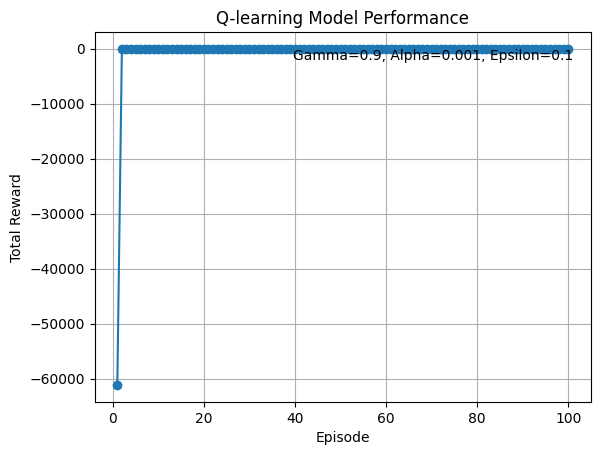

In [10]:
# Plot the episode rewards
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={EPSILON}'
plt.text(NUM_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()